In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

import statsmodels.api 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima

In [2]:
data = statsmodels.api.datasets.sunspots.load_pandas()
df = pd.DataFrame(data = data.data)
df

,YEAR,SUNACTIVITY
0,1700.0,5.0
1,1701.0,11.0
2,1702.0,16.0
3,1703.0,23.0
4,1704.0,36.0
...,...,...
304,2004.0,40.4
305,2005.0,29.8
306,2006.0,15.2
307,2007.0,7.5


In [3]:

############ DATA PREPROCESSING ##############


In [4]:
df.index = (df['YEAR'])
del df['YEAR'] 
df

,SUNACTIVITY
YEAR,
1700.0,5.0
1701.0,11.0
1702.0,16.0
1703.0,23.0
1704.0,36.0
...,...
2004.0,40.4
2005.0,29.8
2006.0,15.2


In [5]:
df.describe(include = "all")

,SUNACTIVITY
count,309.000000
mean,49.752104
std,40.452595
min,0.000000
25%,16.000000
50%,40.000000
75%,69.800000
max,190.200000


In [6]:
# заміна SUNACTIVITY=0 на SUNACTIVITY=0.000001 - для Multiplicative_decomposition

df.loc[(df.SUNACTIVITY == 0.0), 'SUNACTIVITY'] = 0.000001
df.describe(include = "all")

,SUNACTIVITY
count,309.000000
mean,49.752104
std,40.452595
min,0.000001
25%,16.000000
50%,40.000000
75%,69.800000
max,190.200000


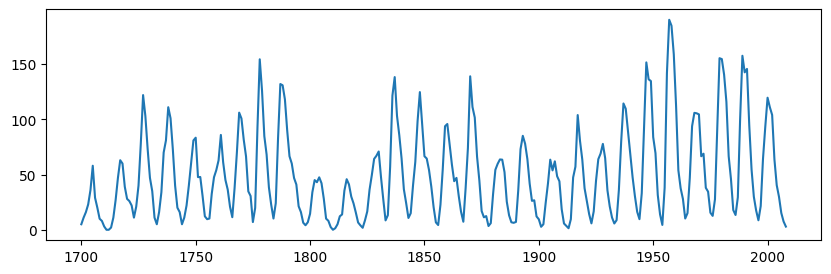

In [7]:
mpl.rcParams['figure.figsize'] = [10, 3]
plt.plot(df)
plt.show()

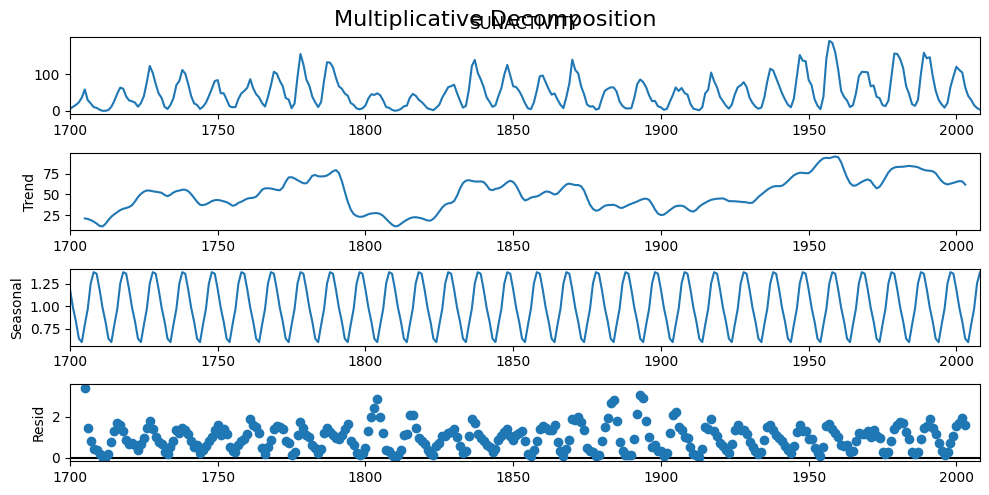

In [8]:
# Multiplicative_decomposition

multiplicative_decomposition = seasonal_decompose(df['SUNACTIVITY'], model='multiplicative', period=10)

mpl.rcParams['figure.figsize'] = [10, 5]
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[1, 1, 1, 1])
plt.show()

In [9]:
# Перевірка на стаціонарність 
# ADF Test (Розширений тест Дікі Фуллера) 

result = adfuller(df, autolag='AIC')    
print(f'ADF-статистика: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Критичні значення:')
    print(f'   {key}, {value}')

ADF-статистика: -2.8377807257166943
p-value: 0.053076421625065415
Критичні значення:
   1%, -3.4523371197407404
Критичні значення:
   5%, -2.871222860740741
Критичні значення:
   10%, -2.571929211111111


In [10]:
# ADF Test: p-value > 0.05, ряд не стаціонарний
# детрендування не проводимо, т.к. це виконає ARIMA 
# проведемо десезонізацію

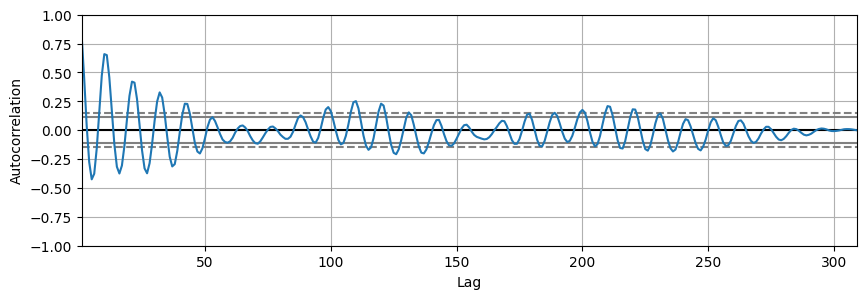

In [11]:
# Тест на сезонність

from pandas.plotting import autocorrelation_plot
mpl.rcParams['figure.figsize'] = [10, 3]
autocorrelation_plot(df['SUNACTIVITY'])
plt.show()

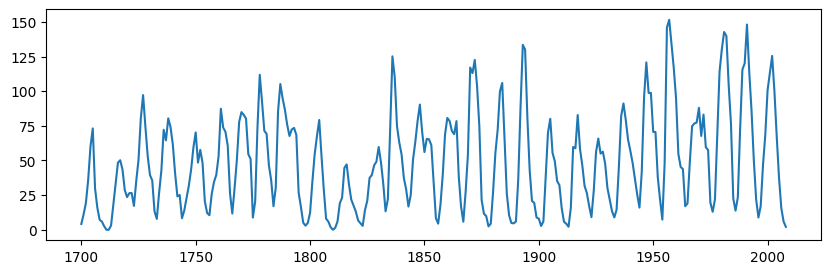

In [12]:
# Десезонізація

multiplicative_decomposition = seasonal_decompose(df['SUNACTIVITY'], model='multiplicative', period=10)
deseasonalized = df['SUNACTIVITY'].values / multiplicative_decomposition.seasonal

plt.plot(deseasonalized)
plt.show()

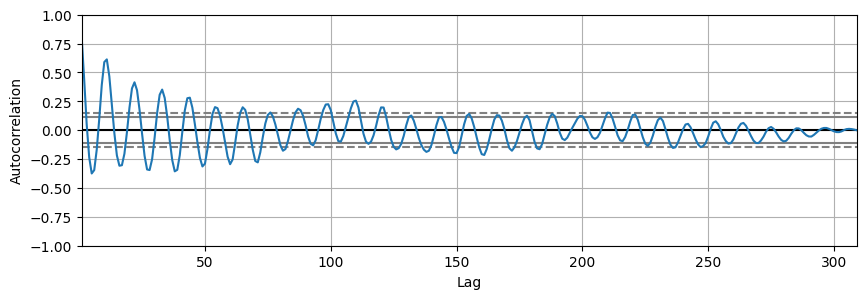

In [13]:
# Тест на сезонність після десезонізації

from pandas.plotting import autocorrelation_plot
autocorrelation_plot(deseasonalized)
plt.show()

In [14]:
# Перевірка на стаціонарність після десезонізації
# ADF Test (Розширений тест Дікі Фуллера) 

result = adfuller(deseasonalized, autolag='AIC')
print(f'ADF-статистика: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Критичні значення:')
    print(f'   {key}, {value}')

ADF-статистика: -2.959729838770192
p-value: 0.0388301271640271
Критичні значення:
   1%, -3.4523371197407404
Критичні значення:
   5%, -2.871222860740741
Критичні значення:
   10%, -2.571929211111111


In [15]:
# "Десезонізований" датафрейм

df_des = pd.DataFrame() 
df_des['SUNACTIVITY'] = deseasonalized
df_des.index = df.index

df_des

,SUNACTIVITY
YEAR,
1700.0,4.211167
1701.0,11.182125
1702.0,19.303363
1703.0,36.058166
1704.0,60.051472
...,...
2004.0,67.391096
2005.0,37.580560
2006.0,15.656162


In [16]:

############ ARIMA MODEL, MODEL EVALUATION ##############


In [18]:
# ARIMA з десезонізованим рядом 

model_1 = auto_arima(df_des, trace=True, error_action='ignore', suppress_warnings=True)
model_1.fit(df_des)

test = df_des[df_des.index < 1751]
test.column = 'SUNACTIVITY'
test.head()

prediction = model_1.predict(n_periods=len(test))
prediction = pd.DataFrame(prediction, columns=['Prediction'])
prediction.index = test.index
prediction

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2564.339, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2767.143, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2691.297, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2696.606, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2765.143, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2561.952, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2580.522, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=2584.370, Time=0.58 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2563.278, Time=0.57 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2561.280, Time=0.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2563.264, Time=0.39 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, T

C:\Users\MyWork\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Prediction
YEAR,
1700.0,24.459001
1701.0,55.576127
1702.0,83.116387
1703.0,98.959424
1704.0,99.259855
1705.0,85.257573
1706.0,62.462616
1707.0,38.603283
1708.0,21.071330


MAD: 23.9478
MSE: 884.7757
MAPE: 1573099.5237
MPE: -1573099.4468
Стандартна похибка: 29.7452


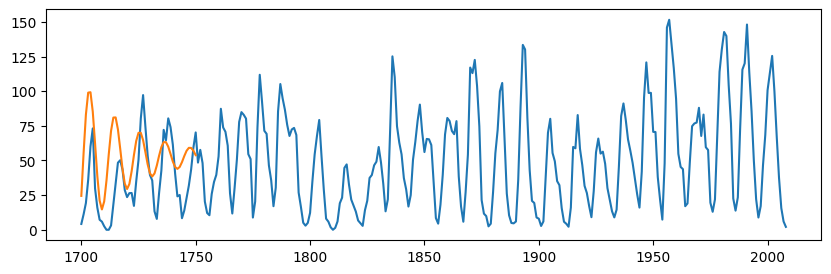

In [19]:
def metrics(real, forecast):
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

    
metrics(test['SUNACTIVITY'], prediction['Prediction'])


plt.plot(df_des)
plt.plot(prediction)
plt.show()

In [20]:
# прогноз приблизно реальний на невеликий період, 20-25 років

In [21]:
# ARIMA з оригинальним рядом 

model_2 = auto_arima(df, trace=True, error_action='ignore', suppress_warnings=True)
model_2.fit(df)

test = df[df.index < 1751]
test.column = 'SUNACTIVITY'
test.head()

prediction = model_2.predict(n_periods=len(test))
prediction = pd.DataFrame(prediction, columns=['Prediction'])
prediction.index = test.index
prediction

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2578.271, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2835.116, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2730.690, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2743.278, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2833.116, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2611.999, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2575.206, Time=0.37 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2597.162, Time=0.26 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=2578.300, Time=0.59 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2574.924, Time=0.33 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.45 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=2576.690, Time=0.27 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, T

C:\Users\MyWork\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Prediction
YEAR,
1700.0,25.823885
1701.0,55.697823
1702.0,79.746206
1703.0,90.630207
1704.0,85.708851
1705.0,67.582655
1706.0,42.920521
1707.0,20.057197
1708.0,6.211590


MAD: 31.8924
MSE: 1432.6859
MAPE: 1810464.1407
MPE: -1810463.7845
Стандартна похибка: 37.8508


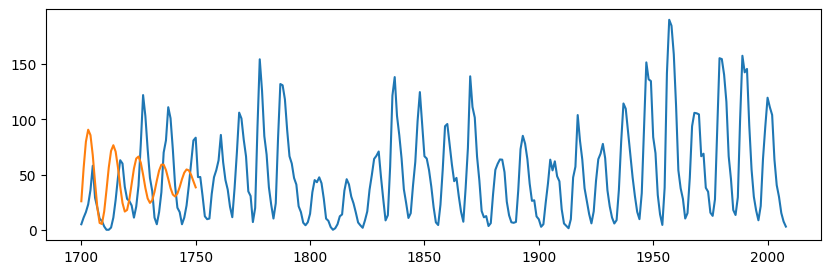

In [22]:
def metrics(real, forecast):
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 

    
metrics(test['SUNACTIVITY'], prediction['Prediction'])


plt.plot(df)
plt.plot(prediction)
plt.show()

In [23]:
# прогноз приблизно реальний на невеликий період, 20-25 років

In [24]:

############ FORECAST ##############


In [25]:
# model 1 (deseasonised)

forecast = model_1.predict(n_periods=22)

year = [i for i in range(2009, 2031)]
forecast = pd.DataFrame(forecast, columns=['Prediction'])

forecast['Year'] = year
forecast.index = forecast['Year']
del forecast['Year']

forecast

C:\Users\MyWork\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Prediction
Year,
2009,24.459001
2010,55.576127
2011,83.116387
2012,98.959424
2013,99.259855
2014,85.257573
2015,62.462616
2016,38.603283
2017,21.071330


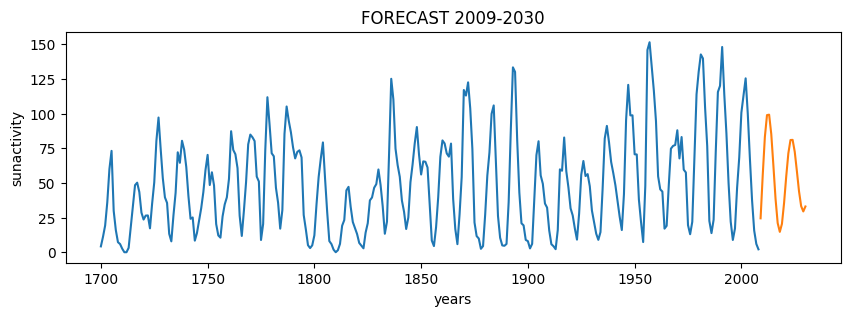

In [26]:
plt.plot(df_des)
plt.plot(forecast)
plt.gca().set(title='FORECAST 2009-2030', xlabel='years', ylabel='sunactivity')
plt.show()

[Text(0.5, 1.0, 'FORECAST 2009-2030'),
 Text(0.5, 0, 'years'),
 Text(0, 0.5, 'sunactivity')]

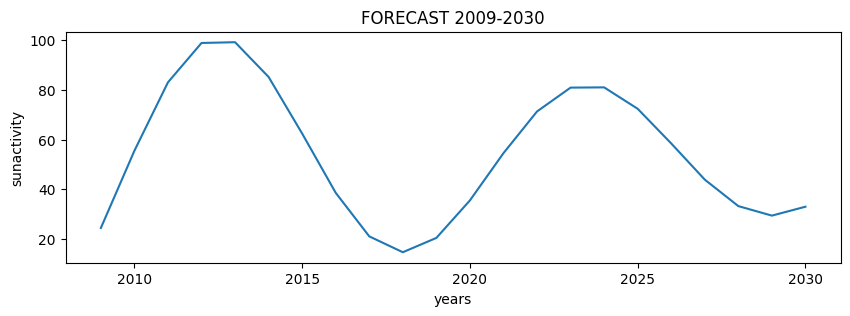

In [27]:
plt.plot(forecast['Prediction'])
plt.gca().set(title='FORECAST 2009-2030', xlabel='years', ylabel='sunactivity')

In [28]:
# model 2 (original data)

forecast = model_2.predict(n_periods=22)

year = [i for i in range(2009, 2031)]
forecast = pd.DataFrame(forecast, columns=['Prediction'])

forecast['Year'] = year
forecast.index = forecast['Year']
del forecast['Year']

forecast

C:\Users\MyWork\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,Prediction
Year,
2009,25.823885
2010,55.697823
2011,79.746206
2012,90.630207
2013,85.708851
2014,67.582655
2015,42.920521
2016,20.057197
2017,6.211590


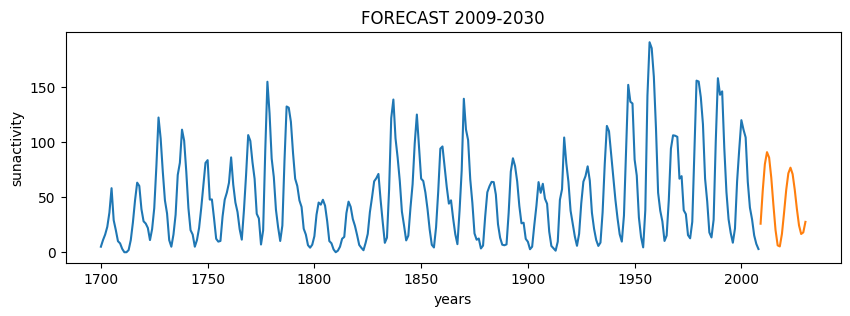

In [29]:
plt.plot(df)
plt.plot(forecast)
plt.gca().set(title='FORECAST 2009-2030', xlabel='years', ylabel='sunactivity')
plt.show()

[Text(0.5, 1.0, 'FORECAST 2009-2030'),
 Text(0.5, 0, 'years'),
 Text(0, 0.5, 'sunactivity')]

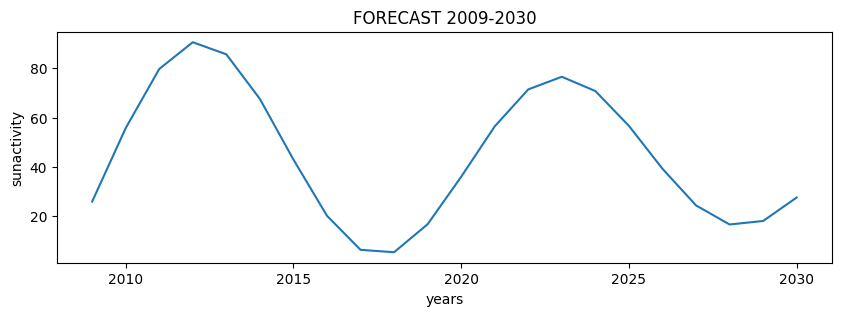

In [30]:
plt.plot(forecast['Prediction'])
plt.gca().set(title='FORECAST 2009-2030', xlabel='years', ylabel='sunactivity')